# FullClass-TrainCNN(InceptionV3)_NoFreezModel_ClassImbalance-byManualCopyingOversampling

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [4]:
train_dataset_path='D:/DatasetMedicalWasteCroppedBalancedOversamplingCopying/'

## Testing Set DIR

In [2]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [3]:
img_height=299
img_width=299
batch_size=64

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15342 files belonging to 41 classes.
Using 12274 files for training.


In [6]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15342 files belonging to 41 classes.
Using 3068 files for validation.


In [8]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [9]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [10]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


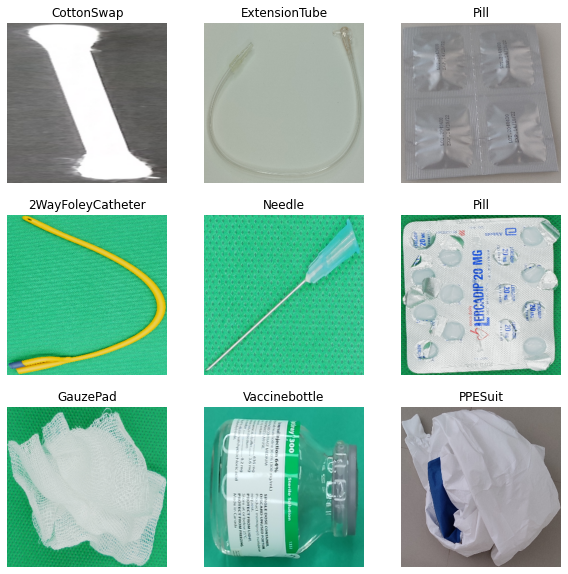

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
model = tf.keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
EPOCHS = 400
checkpoint_filepath = 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedCPOverSampling/ClassImbalancedCPOverSampling-epoch{epoch:03d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback]) 

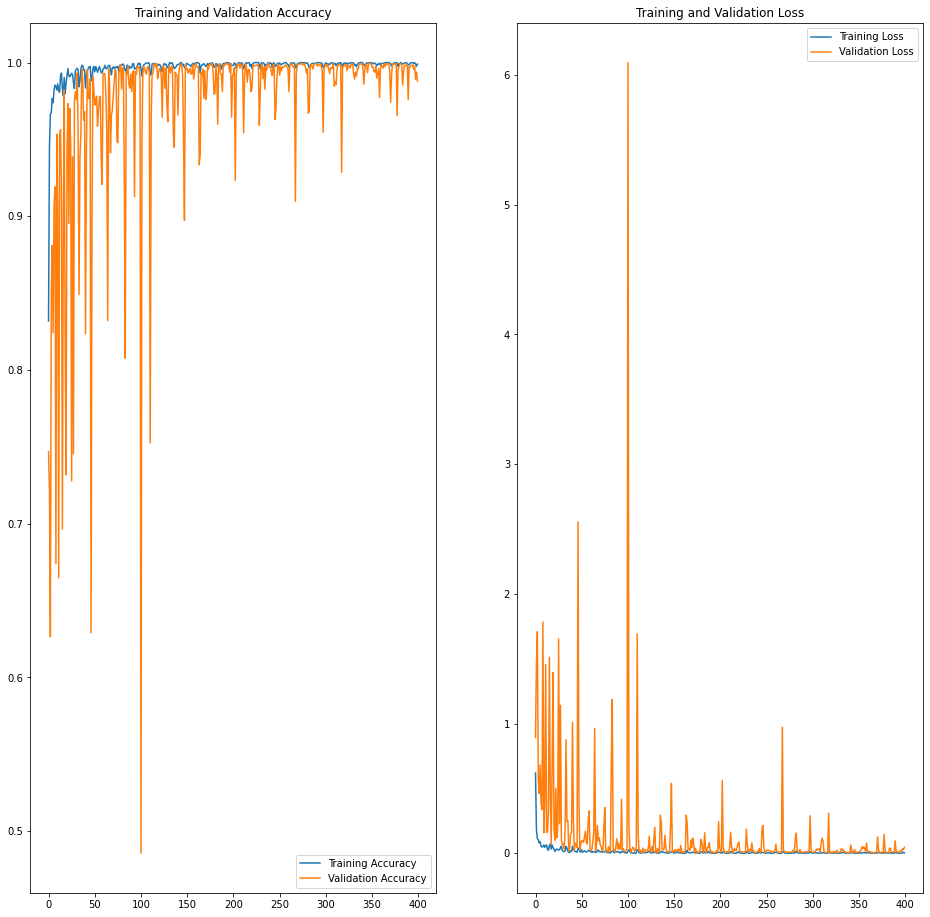

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 15s 371ms/step - loss: 12.1582 - accuracy: 0.2943
test_indoor_ds_results:test loss, test acc: [12.158154487609863, 0.2943143844604492]


In [23]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 27s 450ms/step - loss: 4.7039 - accuracy: 0.5092
test_outdoor_ds_results:test loss, test acc: [4.703945159912109, 0.509235680103302]


In [24]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 9s 203ms/step - loss: 2.7312 - accuracy: 0.7053
test_belt_ds_results:test loss, test acc: [2.731245517730713, 0.7053490281105042]


In [16]:
# Read path of trained model
import os, os.path
trained_path = 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedCPOverSampling/'
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths


['D:/ModelMedicalWasteCheckpoint/ClassImbalancedCPOverSampling/ClassImbalancedCPOverSampling-epoch001-val_acc0.75.pb',
 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedCPOverSampling/ClassImbalancedCPOverSampling-epoch002-val_acc0.72.pb',
 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedCPOverSampling/ClassImbalancedCPOverSampling-epoch003-val_acc0.63.pb',
 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedCPOverSampling/ClassImbalancedCPOverSampling-epoch004-val_acc0.85.pb',
 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedCPOverSampling/ClassImbalancedCPOverSampling-epoch005-val_acc0.88.pb',
 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedCPOverSampling/ClassImbalancedCPOverSampling-epoch006-val_acc0.82.pb',
 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedCPOverSampling/ClassImbalancedCPOverSampling-epoch007-val_acc0.91.pb',
 'D:/ModelMedicalWasteCheckpoint/ClassImbalancedCPOverSampling/ClassImbalancedCPOverSampling-epoch008-val_acc0.92.pb',
 'D:/ModelMedicalWasteCheckpoint/ClassImbalanced

In [17]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []
for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    print(f"Epoch{lm_idx+1:02d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 8s 205ms/step - loss: 1.8366 - accuracy: 0.5979
Epoch01 
 test_indoor_acc=0.239130437374115 
 test_outdoor_acc=0.4162420332431793 
 test_belt_acc=0.5979147553443909
35/35 [==============================] - 5s 137ms/step - loss: 4.5801 - accuracy: 0.4361
Epoch02 
 test_indoor_acc=0.2028985470533371 
 test_outdoor_acc=0.2866241931915283 
 test_belt_acc=0.4360834062099457
35/35 [==============================] - 5s 139ms/step - loss: 3.3330 - accuracy: 0.4370
Epoch03 
 test_indoor_acc=0.22965440154075623 
 test_outdoor_acc=0.18248407542705536 
 test_belt_acc=0.43699002265930176
35/35 [==============================] - 5s 139ms/step - loss: 1.9364 - accuracy: 0.5879
Epoch04 
 test_indoor_acc=0.22575250267982483 
 test_outdoor_acc=0.3977707028388977 
 test_belt_acc=0.5879420042037964
35/35 [==============================] - 5s 136ms/step - loss: 2.1665 - accuracy: 0.6319
Epoch05 
 test_indoor_acc=0.4559643268585205 
 test_outdoor_acc=0.42292994260787

Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

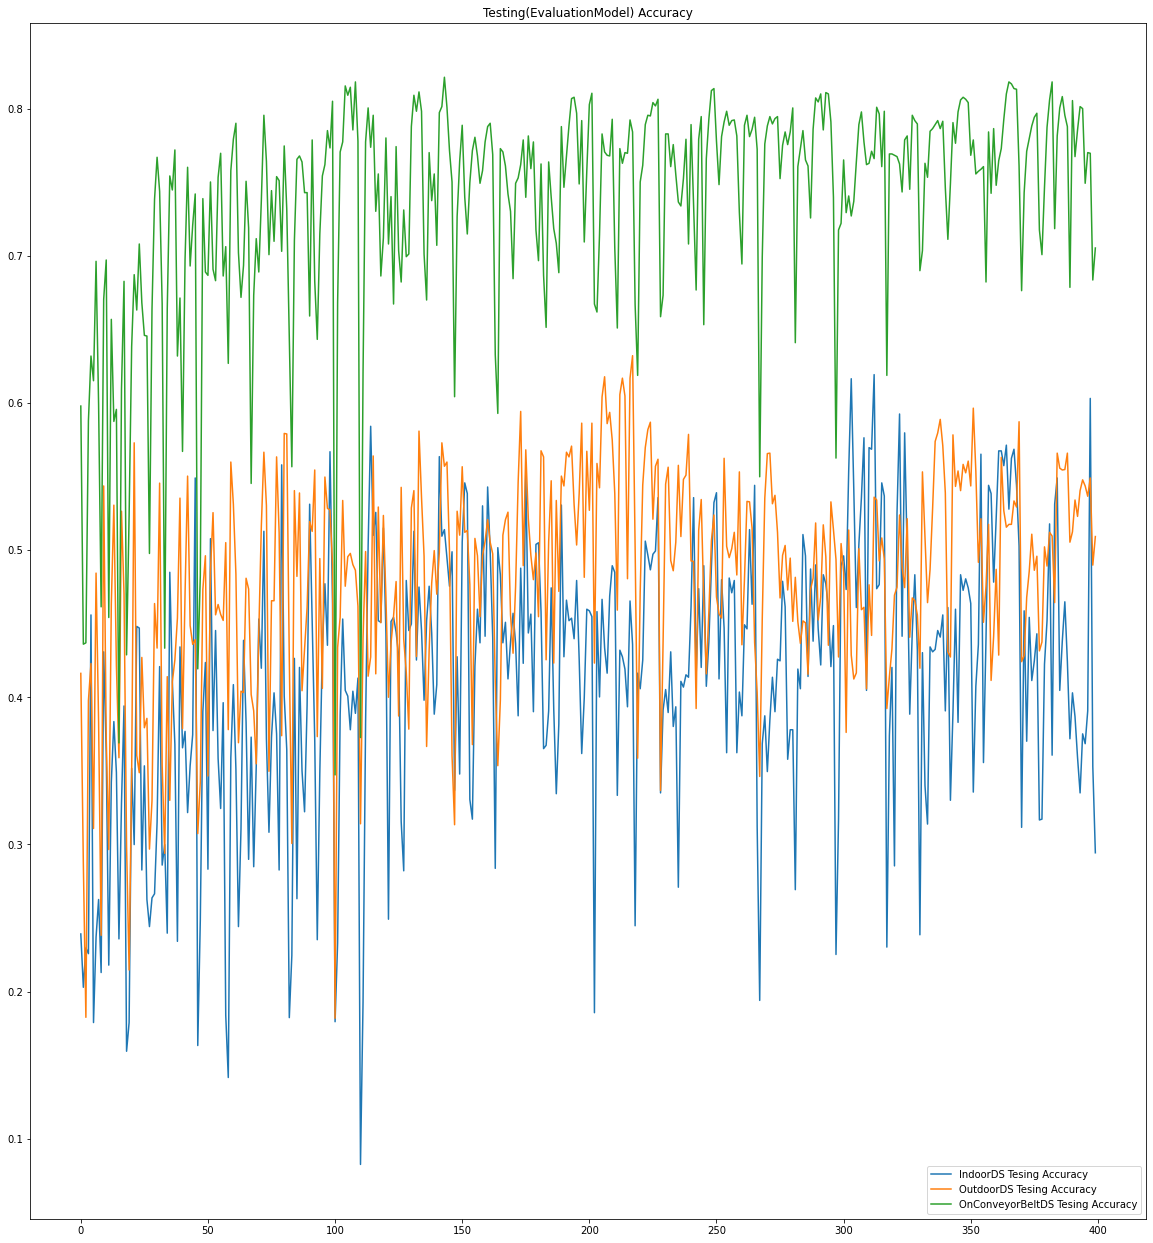

In [19]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(EPOCHS)

plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')



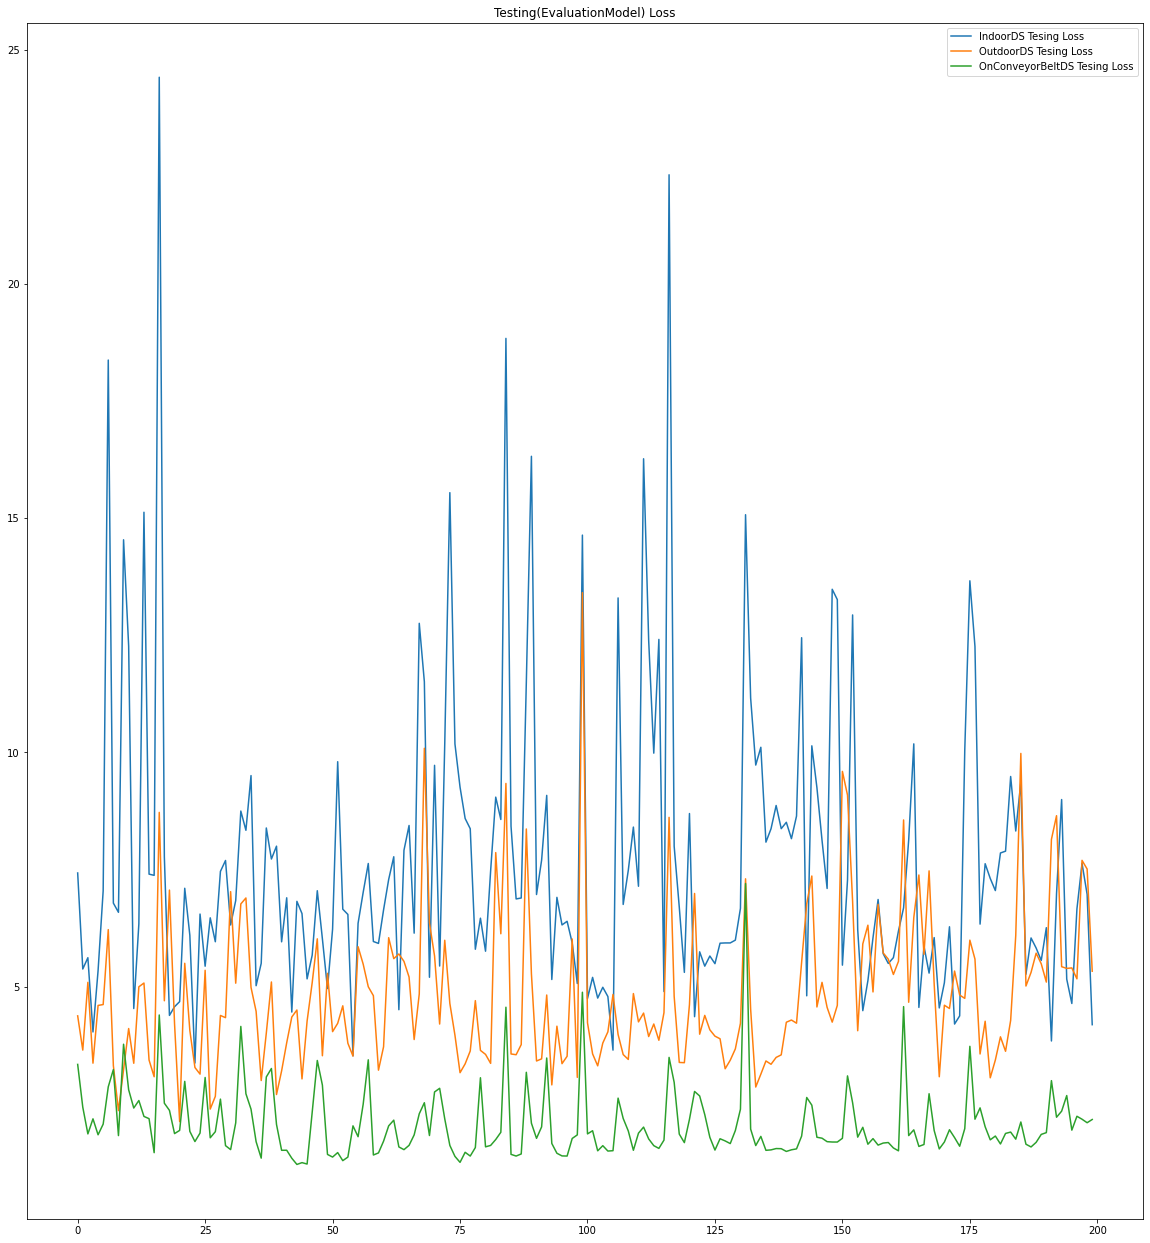

In [ ]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [20]:
test_indoor_acc

[0.239130437374115,
 0.2028985470533371,
 0.22965440154075623,
 0.22575250267982483,
 0.4559643268585205,
 0.17892976105213165,
 0.23690077662467957,
 0.262541800737381,
 0.21293199062347412,
 0.43088072538375854,
 0.3628762662410736,
 0.21794871985912323,
 0.3422519564628601,
 0.3835005462169647,
 0.348940908908844,
 0.23578594624996185,
 0.3277592062950134,
 0.3940914273262024,
 0.15942029654979706,
 0.17892976105213165,
 0.35172799229621887,
 0.2998885214328766,
 0.4481605291366577,
 0.4470457136631012,
 0.28260868787765503,
 0.35340023040771484,
 0.262541800737381,
 0.2441471517086029,
 0.2636566460132599,
 0.2664436995983124,
 0.3149386942386627,
 0.4208472669124603,
 0.285953164100647,
 0.2998885214328766,
 0.23968784511089325,
 0.48494982719421387,
 0.4108138382434845,
 0.3678929805755615,
 0.23411370813846588,
 0.4342252016067505,
 0.3656633198261261,
 0.37681159377098083,
 0.3216276466846466,
 0.35340023040771484,
 0.3745819330215454,
 0.5490524172782898,
 0.16332218050956726,

In [21]:
test_outdoor_acc

[0.4162420332431793,
 0.2866241931915283,
 0.18248407542705536,
 0.3977707028388977,
 0.42292994260787964,
 0.3108280301094055,
 0.484394907951355,
 0.3831210136413574,
 0.2382165640592575,
 0.5436305999755859,
 0.37229299545288086,
 0.29649680852890015,
 0.4633758068084717,
 0.5305732488632202,
 0.4216560423374176,
 0.3589172065258026,
 0.5264331102371216,
 0.4703821539878845,
 0.2987261116504669,
 0.21464967727661133,
 0.34745222330093384,
 0.5729299187660217,
 0.3605095446109772,
 0.3487261235713959,
 0.4270700514316559,
 0.3792993724346161,
 0.3856687843799591,
 0.29681527614593506,
 0.32961782813072205,
 0.4636942744255066,
 0.4334394931793213,
 0.5455414056777954,
 0.35382166504859924,
 0.29394903779029846,
 0.41401273012161255,
 0.32993629574775696,
 0.41050955653190613,
 0.4254777133464813,
 0.45382165908813477,
 0.5353503227233887,
 0.3786624073982239,
 0.4703821539878845,
 0.5503184795379639,
 0.4487261176109314,
 0.435987263917923,
 0.4391719698905945,
 0.3073248267173767,
 

In [22]:
test_belt_acc

[0.5979147553443909,
 0.4360834062099457,
 0.43699002265930176,
 0.5879420042037964,
 0.6319129467010498,
 0.6151404976844788,
 0.6962828636169434,
 0.5988214015960693,
 0.46146872639656067,
 0.6704442501068115,
 0.6971895098686218,
 0.45421576499938965,
 0.656844973564148,
 0.5874886512756348,
 0.5956482291221619,
 0.3689936399459839,
 0.6092475056648254,
 0.6826835870742798,
 0.42883047461509705,
 0.5235720872879028,
 0.6382592916488647,
 0.6872166991233826,
 0.6631913185119629,
 0.7080689072608948,
 0.6681777238845825,
 0.645965576171875,
 0.6455122232437134,
 0.4977334439754486,
 0.6636446118354797,
 0.7384406328201294,
 0.7669990658760071,
 0.7438803315162659,
 0.667271077632904,
 0.43336355686187744,
 0.6640979051589966,
 0.754306435585022,
 0.7447869181632996,
 0.7719854712486267,
 0.6319129467010498,
 0.6713508367538452,
 0.5670897364616394,
 0.6976428031921387,
 0.7601994276046753,
 0.6931096911430359,
 0.7207615375518799,
 0.7420670986175537,
 0.41931095719337463,
 0.48277425

In [23]:
test_indoor_loss

[6.496720790863037,
 5.713625431060791,
 4.71214485168457,
 6.263082504272461,
 3.453096866607666,
 7.9040446281433105,
 8.11361312866211,
 7.0347371101379395,
 12.332484245300293,
 4.33341121673584,
 4.861865043640137,
 6.711369037628174,
 6.256961345672607,
 5.113322734832764,
 5.991156578063965,
 7.835694313049316,
 6.30490779876709,
 4.827976703643799,
 8.645039558410645,
 10.039078712463379,
 4.901276588439941,
 6.281975269317627,
 3.4351065158843994,
 4.017536163330078,
 5.727602958679199,
 5.217472553253174,
 8.070518493652344,
 8.679619789123535,
 11.073946952819824,
 11.989091873168945,
 5.4080071449279785,
 5.23341703414917,
 9.242911338806152,
 7.283170700073242,
 9.444870948791504,
 3.5083870887756348,
 4.8488898277282715,
 7.473313808441162,
 11.829590797424316,
 5.443498134613037,
 5.327727317810059,
 5.526420593261719,
 9.508743286132812,
 6.213253021240234,
 4.655375003814697,
 2.726351022720337,
 11.636024475097656,
 7.580629348754883,
 4.276087760925293,
 4.2628831863

In [24]:
test_outdoor_loss

[3.1085636615753174,
 4.339629650115967,
 6.4642863273620605,
 3.9963274002075195,
 4.173846244812012,
 5.253872871398926,
 2.8483612537384033,
 4.151459693908691,
 9.182580947875977,
 2.6119673252105713,
 4.401516437530518,
 4.6598944664001465,
 3.4310367107391357,
 2.9662318229675293,
 5.457932472229004,
 4.736913204193115,
 2.8566956520080566,
 3.4681780338287354,
 6.196632385253906,
 9.926933288574219,
 6.276131629943848,
 2.3265626430511475,
 6.620080471038818,
 7.701290130615234,
 4.363893985748291,
 3.8224544525146484,
 6.2367119789123535,
 7.517578125,
 6.3482279777526855,
 3.379420042037964,
 4.357460021972656,
 2.591386556625366,
 6.5011091232299805,
 6.4360456466674805,
 3.9805028438568115,
 5.770979404449463,
 4.636534214019775,
 4.204639434814453,
 4.106176853179932,
 3.432382583618164,
 4.610519886016846,
 3.5257949829101562,
 3.1908371448516846,
 4.389689922332764,
 4.228221893310547,
 4.658248424530029,
 7.1228766441345215,
 5.340795040130615,
 3.902653932571411,
 3.703

In [25]:
test_belt_loss

[1.8366297483444214,
 4.580109596252441,
 3.3329684734344482,
 1.9364309310913086,
 2.166508197784424,
 2.0727243423461914,
 1.5172218084335327,
 2.111757278442383,
 3.8588919639587402,
 1.5964100360870361,
 1.492478847503662,
 2.9555678367614746,
 1.880184292793274,
 2.6435606479644775,
 2.617065668106079,
 5.625946044921875,
 2.412240743637085,
 1.7047080993652344,
 3.6690797805786133,
 3.0331153869628906,
 2.1836371421813965,
 1.8327652215957642,
 2.1412291526794434,
 1.9263966083526611,
 1.9192073345184326,
 2.0920701026916504,
 2.289790391921997,
 3.5177881717681885,
 2.015010356903076,
 1.5179357528686523,
 1.2836382389068604,
 1.3975427150726318,
 2.2535009384155273,
 5.422384262084961,
 1.9747217893600464,
 1.2297154664993286,
 1.5435001850128174,
 1.2610522508621216,
 2.7430875301361084,
 2.563166856765747,
 3.1249442100524902,
 2.0742852687835693,
 1.556047797203064,
 1.7608106136322021,
 1.9751865863800049,
 1.7708228826522827,
 5.515367031097412,
 3.733457326889038,
 1.6159

## Load Last Epoch and test in each class

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model('E:/ModelMedicalWasteCheckpoint/ClassImbalancedCPOverSampling/ClassImbalancedCPOverSampling-epoch400-val_acc0.99.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_train_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_train_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_train_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_train_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_train_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_train_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_train_indoor)},{len(y_train_indoor)}")
print(f"train_outdoor num x,y : {len(x_train_outdoor)},{len(y_train_outdoor)}")
print(f"train_belt num x,y : {len(x_train_belt)},{len(y_train_belt)}")
x_all = np.concatenate([x_train_indoor,x_train_outdoor,x_train_belt],axis=0)
y_all = np.concatenate([y_train_indoor,y_train_outdoor,y_train_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [2]:
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=3683
FP=3457
acc=0.5158263305322129
all check = 7140


In [3]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')

1WayConnectorforFoley acc = 36.206896551724135%
2WayConnectorforFoley acc = 50.34013605442177%
2WayFoleyCatheter acc = 44.776119402985074%
3WayConnectorforFoley acc = 65.8119658119658%
3Waystopcock acc = 60.36036036036037%
AlcoholBottle acc = 70.0%
AlcoholPad acc = 30.952380952380953%
BootCover acc = 59.036144578313255%
CottonBall acc = 62.27544910179641%
CottonSwap acc = 44.75524475524475%
Dilator acc = 35.04273504273504%
DisposableInfusionSet acc = 35.39823008849557%
ExtensionTube acc = 38.21138211382114%
FaceShield acc = 33.33333333333333%
FrontLoadSyringe acc = 8.849557522123893%
GauzePad acc = 43.18181818181818%
Glove acc = 25.297619047619047%
GuideWire acc = 9.821428571428571%
LiquidBottle acc = 50.0%
Mask acc = 60.0%
NGTube acc = 31.61290322580645%
NasalCannula acc = 15.04424778761062%
Needle acc = 65.71428571428571%
OxygenMask acc = 30.075187969924812%
PPESuit acc = 26.61290322580645%
PharmaceuticalProduct acc = 74.76635514018692%
Pill acc = 87.11484593837535%
PillBottle acc = 